本指南将训练一个神经网络模型，对运动鞋和衬衫等服装图像进行分类。即使您不理解所有细节也没关系；这只是对完整 TensorFlow 程序的快速概述，详细内容会在您实际操作的同时进行介绍。

本指南使用了 [tf.keras](https://tensorflow.google.cn/guide/keras)，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


# 导入 Fashion MNIST 衣物数据集
本指南使用 [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集，该数据集包含 10 个类别的 70,000 个灰度图像。这些图像以低分辨率（28x28 像素）展示了单件衣物，如下所示：

![Fashion MNIST 衣物数据集](https://tensorflow.google.cn/images/fashion-mnist-sprite.png)

Fashion MNIST 旨在临时替代经典 MNIST 数据集，后者常被用作计算机视觉机器学习程序的“Hello, World”。MNIST 数据集包含手写数字（0、1、2 等）的图像，其格式与您将使用的衣物图像的格式相同。

本指南使用 Fashion MNIST 来实现多样化，因为它比常规 MNIST 更具挑战性。这两个数据集都相对较小，都用于验证某个算法是否按预期工作。对于代码的测试和调试，它们都是很好的起点。

在本指南中，我们使用 60,000 个图像来训练网络，使用 10,000 个图像来评估网络学习对图像分类的准确率。您可以直接从 TensorFlow 访问 Fashion MNIST。请运行以下代码，直接从 TensorFlow 中导入和加载 Fashion MNIST 数据：

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

加载数据集会返回四个 NumPy 数组：

`train_images` 和 `train_labels` 数组是训练集，即模型用于学习的数据。
测试集、`test_images` 和 `test_labels` 数组会被用来对模型进行测试。
图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。标签是整数数组，介于 0 到 9 之间。这些标签对应于图像所代表的服装类：

|标签|类|
|:---:|:---:|
|0|T恤/上衣|
|1|裤子|
|2|套头衫|
|3|连衣裙|
|4|外套|
|5|凉鞋|
|6|衬衫|
|7|运动鞋|
|8|包|
|9|短靴|

每个图像都会被映射到一个标签。由于数据集不包括类名称，请将它们存储在下方，供稍后绘制图像时使用：

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 浏览数据
在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [4]:
train_images.shape

(60000, 28, 28)

同样，训练集中有 60,000 个标签：

In [5]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [7]:
test_images.shape

(10000, 28, 28)

测试集包含 10,000 个图像标签：

In [8]:
len(test_labels)

10000

# 预处理数据
在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：

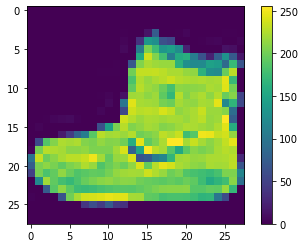

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对训练集和测试集进行预处理：

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示训练集中的前 25 个图像，并在每个图像下方显示类名称。

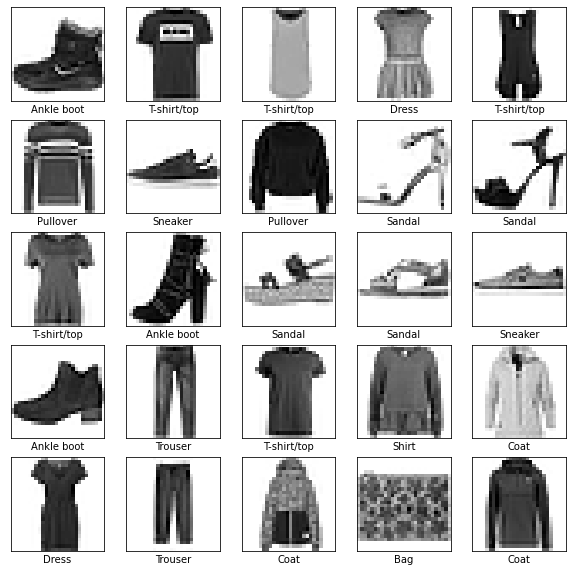

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# 构建模型
构建神经网络需要先配置模型的层，然后再编译模型。

## 设置层
神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。

大多数深度学习都包括将简单的层链接在一起。大多数层（如 tf.keras.layers.Dense）都具有在训练期间才会学习的参数。

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

该网络的第一层 `tf.keras.layers.Flatten` 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 `tf.keras.layers.Dense` 层的序列。它们是密集连接或全连接神经层。第一个 Dense 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

## 编译模型
在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数 - 用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。
- 优化器 - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标 - 用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 训练模型
训练神经网络模型需要执行以下步骤：

1. 将训练数据馈送给模型。在本例中，训练数据位于 train_images 和 train_labels 数组中。
2. 模型学习将图像和标签关联起来。
3. 要求模型对测试集（在本例中为 test_images 数组）进行预测。
4. 验证预测是否与 test_labels 数组中的标签相匹配。

## 向模型馈送数据
要开始训练，请调用 model.fit 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4984 - accuracy: 0.8240
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3718 - accuracy: 0.8669
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3342 - accuracy: 0.8792
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3127 - accuracy: 0.8849
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2933 - accuracy: 0.8931
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2799 - accuracy: 0.8963
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2663 - accuracy: 0.9011
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2567 - accuracy: 0.9047
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2463 - accuracy: 0.9091
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

## 评估准确率
接下来，比较模型在测试数据集上的表现：

In [16]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3345 - accuracy: 0.8865 - 443ms/epoch - 1ms/step

Test accuracy: 0.8865000009536743


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表过拟合。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。有关更多信息，请参阅以下内容：

- [演示过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [避免过拟合的策略](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

## 进行预测
在模型经过训练后，您可以使用它对一些图像进行预测。模型具有线性输出，即 [logits](https://developers.google.com/machine-learning/glossary#logits)。您可以附加一个 softmax 层，将 logits 转换成更容易理解的概率。

In [17]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [18]:
predictions[0]

array([8.9489582e-08, 2.1990760e-12, 4.3832667e-11, 5.5864909e-12,
       1.6875470e-09, 2.4548671e-04, 7.6963298e-09, 1.8050924e-03,
       6.2839098e-09, 9.9794930e-01], dtype=float32)

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。您可以看到哪个标签的置信度值最大：

In [19]:
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 class_names[9]。通过检查测试标签发现这个分类是正确的：

In [20]:
test_labels[0]

9

您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [21]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

## 验证预测结果
在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

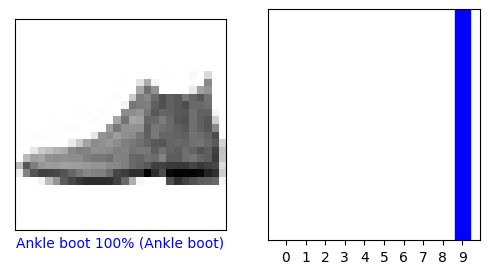

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

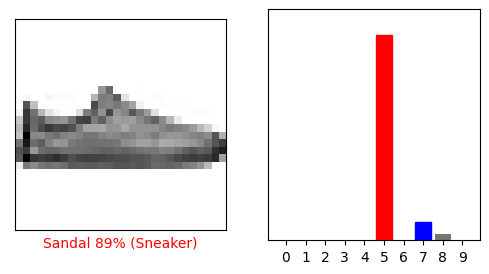

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

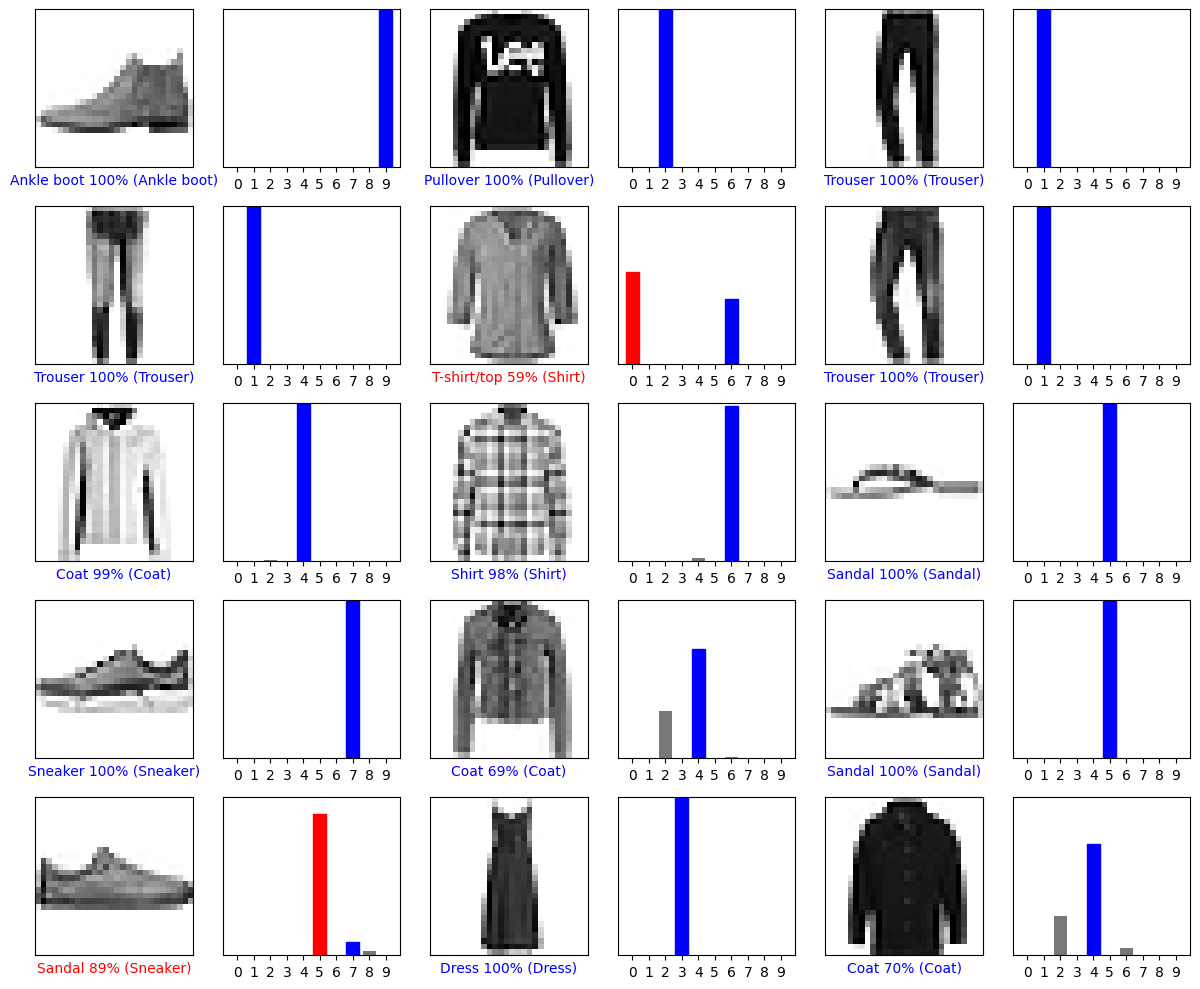

In [24]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# 使用训练好的模型
最后，使用训练好的模型对单个图像进行预测。

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` 模型经过了优化，可同时对一个批或一组样本进行预测。因此，即便您只使用一个图像，您也需要将其添加到列表中：

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


现在预测这个图像的正确标签：

In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[2.6708931e-05 4.9709563e-11 9.9909365e-01 7.4953732e-10 8.4809156e-04
  5.2705279e-13 3.1616317e-05 8.1754462e-17 9.4936725e-10 4.5862515e-11]]


In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`keras.Model.predict` 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [29]:
np.argmax(predictions_single[0])

2

该模型会按照预期预测标签。